# Предварительный анализ данных и построение признаков в задачах машинного перевода

Выполнила студентка группы ПМ18-1 факультета "Прикладная математика и анализ больших данных" Аблязова Алия.

### Установка необходимых библиотек

In [ ]:
import os, sys
import pandas as pd
import string
from string import digits
from sklearn.utils import shuffle
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import seaborn as sns
import matplotlib as plt
from sklearn.model_selection import train_test_split
import nltk.translate.bleu_score as bleu

## Исходные данные

Данные представляют собой текстовый файл с соответствующими друг другу предложениями на английском и немецокм языках.

In [ ]:
data = open('eng-deu.txt', 'r')
print(data.read(300))

Hi.	Hallo!
Hi.	Grüß Gott!
Run!	Lauf!
Wow!	Potzdonner!
Wow!	Donnerwetter!
Fire!	Feuer!
Help!	Hilfe!
Help!	Zu Hülf!
Stop!	Stopp!
Wait!	Warte!
Go on.	Mach weiter.
Hello!	Hallo!
I ran.	Ich rannte.
I see.	Ich verstehe.
I see.	Aha.
I try.	Ich probiere es.
I won!	Ich hab gewonnen!
I won!	Ich habe gewonnen!


## Первоначальный анализ данных и подготовка данных

Первым этапом необходимо разделить предложения из файла на языковые пары.

В этой работе предполагается, что нейронная модель машинного перевода будет использовать подход sequence-to-sequence. Данный алгоритм, используя рекуррентные нейронные сети, переводит одну последовательность в другую. Encoder обрабатывает входные данные в виде вектора, в нашем случае соответсвующего предложению на английском, а decoder получает на вход вектор предложения на немецком и выводит само предложение. 

In [ ]:
engsentences = []
deusentences = []

k = 0
for line in open('eng-deu.txt', 'r'):
    k += 1
    if k > 30000:
        break
    if '\t' not in line:
        continue
    engsent, output = line.rstrip().split('\t')
    deusent = output
    engsentences.append(engsent)
    deusentences.append(deusent)

print('Количество предложений на английском:', len(engsentences))
print('Количество предложений на немецком:', len(deusentences))

Количество предложений на английском: 30000
Количество предложений на немецком: 30000


Таким образом, мы сопоставили друг другу предложения на двух языках.

Убедимся, что предложения действительно соответствуют друг другу:

In [ ]:
print(engsentences[120])
print(deusentences[120])

Go away.
Verschwinde!


In [ ]:
dfdata = pd.DataFrame(engsentences, columns =['English sentences'])

dfdata['German sentences'] = deusentences
dfdata['German sentences'] = dfdata['German sentences'].map(lambda a: a.replace('<go>', ''))

dfdata

,English sentences,German sentences
0,Hi.,Hallo!
1,Hi.,Grüß Gott!
2,Run!,Lauf!
3,Wow!,Potzdonner!
4,Wow!,Donnerwetter!
...,...,...
29995,It snowed all night.,Es hat die ganze Nacht geschneit.
29996,It snowed yesterday.,Gestern hat es geschneit.
29997,It tastes very good.,Es schmeckt sehr gut.
29998,It took all evening.,Es dauerte den ganzen Abend.


Проверим, есть ли в датасете отсутствующие значения.

In [ ]:
pd.isnull(dfdata).sum()

English sentences    0
German sentences     0
dtype: int64

Уберем все специальные символы и знаки препинания из предложений.

In [ ]:
exclude = set(string.punctuation) 
dfdata['English sentences']=dfdata['English sentences'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
dfdata['German sentences']=dfdata['German sentences'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
dfdata

,English sentences,German sentences
0,Hi,Hallo
1,Hi,Grüß Gott
2,Run,Lauf
3,Wow,Potzdonner
4,Wow,Donnerwetter
...,...,...
29995,It snowed all night,Es hat die ganze Nacht geschneit
29996,It snowed yesterday,Gestern hat es geschneit
29997,It tastes very good,Es schmeckt sehr gut
29998,It took all evening,Es dauerte den ganzen Abend


In [ ]:
exc = lambda x: ''.join(ch for ch in x if ch not in exclude)
engsentences = list(map(exc, engsentences))
deusentences = list(map(exc, deusentences))

Уберем из датасета цифры:

In [ ]:
remove = str.maketrans('', '', digits)

dfdata['English sentences'] = dfdata['English sentences'].apply(lambda x: x.translate(remove))
dfdata['German sentences'] = dfdata['German sentences'].apply(lambda x: x.translate(remove))

dfdata

,English sentences,German sentences
0,Hi,Hallo
1,Hi,Grüß Gott
2,Run,Lauf
3,Wow,Potzdonner
4,Wow,Donnerwetter
...,...,...
29995,It snowed all night,Es hat die ganze Nacht geschneit
29996,It snowed yesterday,Gestern hat es geschneit
29997,It tastes very good,Es schmeckt sehr gut
29998,It took all evening,Es dauerte den ganzen Abend


In [ ]:
rem = lambda x: x.translate(remove)
engsentences = list(map(rem, engsentences))
deusentences = list(map(rem, deusentences))

# Вариант #1

## Индикаторы начала и конца предложения

Чтобы отделить входные данные декодера от выходных, добавим к первым в начале специальный символ (индикатор), не входящий в предложение: $<start>$, а к выводу $<end>$ в конце предложения.

In [1]:
deusentences_start = []
deusentences_end = []

for sent in deusentences:
    deusent_start = '<start> ' + sent
    deusent_end = sent + ' <end>' 
    deusentences_start.append(deusent_start)
    deusentences_end.append(deusent_end)

print ('Количество предложений с символом начала строки: ', len(deusentences_start))
print ('Количество предложений с символом конца строки: ', len(deusentences_end))

NameError: ignored

Еще раз проверим соответствие предложений:

In [ ]:
print(engsentences[2717])
print(deusentences_start[2717])
print(deusentences_end[2717])

## Токенизация (Tokenization)

Токенизация - необходимый шаг в задаче NLP. С помощью tokenizer из библиотеки Keras мы разделяем предложения на слова, знаки препинания и тд. Метод fit_on_texts индексирует слова в зависимости от частоты появления слова, text_to_sequences преобразует предложения на естественном языке в вектор-последовательность целых чисел.

### Токенизация английских предложений:

In [ ]:
engtokenizer = Tokenizer(num_words = 30000)
engtokenizer.fit_on_texts(engsentences)
engvector = engtokenizer.texts_to_sequences(engsentences)

engindexes = engtokenizer.word_index
maxenglen = max(len(a) for a in engvector)

print('Количество английских уникальных слов в данных:', len(engindexes))
print('Длина самого длинного английского предложения: ', maxenglen)

Количество английских уникальных слов в данных: 4738
Длина самого длинного английского предложения:  6


Создадим список из уникальных слов в английском языке:

In [ ]:
englen = []
for a in engvector:
    englen.append(len(a))

Рассмотрим 10 наиболее часто встречающихся английских слов в датасете.

In [ ]:
first10wordseng = list(engindexes.items())[:11]
print (first10wordseng)

[('tom', 1), ('i', 2), ('you', 3), ('is', 4), ('a', 5), ('it', 6), ("i'm", 7), ('to', 8), ('he', 9), ('the', 10), ('me', 11)]


Так как наиболее часто встречающееся слово это имя собственное, то мы не будем рассматривать его в общей характеристике языка.

In [ ]:
eng10words = []

for pair in first10wordseng:
    engword = list(pair)
    engword.pop(1)
    eng10words.append(engword)
    
eng10words.pop(0)    
print(eng10words)

keng10words = []

for i in eng10words:
    keng10words.append(sum(x.count(engindexes[i[0]]) for x in engvector))
    
print(keng10words)

[['i'], ['you'], ['is'], ['a'], ['it'], ["i'm"], ['to'], ['he'], ['the'], ['me']]
[5251, 3452, 3440, 2509, 2265, 1414, 1322, 1318, 1303, 1273]


In [ ]:
dfengwords = pd.DataFrame(eng10words, columns =['English words'])
dfengwords['Count'] = keng10words

10 наиболее часто встречающихся слов в английском языке.

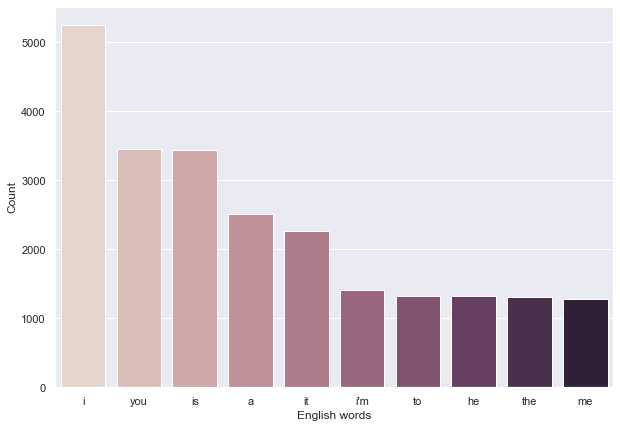

In [ ]:
sns.set(rc={'figure.figsize':(10,7)})
sns.barplot(x="English words", y="Count", data=dfengwords, palette = "ch:.11")

### Токенизация немецких предложений:

Токенизация немецких предложений происходит по такому же алгоритму, как и токенизация английских предложений.

In [ ]:
deutokenizer = Tokenizer(num_words = 30000, filters='')
deutokenizer.fit_on_texts(deusentences_start + deusentences_end)
deu_startvector = deutokenizer.texts_to_sequences(deusentences_start)
deu_endvector = deutokenizer.texts_to_sequences(deusentences_end)

deuindexes = deutokenizer.word_index
maxdeulen = max(len(a) for a in deu_startvector)

print('Количество немецких уникальных слов в данных: ', len(deuindexes))
print('Длина самого длинного немецкого предложения: ', maxdeulen-1)

Количество немецких уникальных слов в данных:  7550
Длина самого длинного немецкого предложения:  12


Создадим список из уникальных слов немецкого языка.

In [ ]:
deulen = []
for a in deu_startvector:
    deulen.append(len(a) - 1)

Рассмотрим 10 наиболее часто встречающихся немецких слов в датасете.

In [ ]:
first10wordsdeu = list(deuindexes.items())[:13]
print (first10wordsdeu)

[('<start>', 1), ('<end>', 2), ('tom', 3), ('ich', 4), ('ist', 5), ('sie', 6), ('das', 7), ('es', 8), ('nicht', 9), ('du', 10), ('er', 11), ('hat', 12), ('wir', 13)]


Очевидно, что не стоит учитывать символы начала и конца строки для анализа естественного языка. Так же, как и в английском, мы не будем рассматривать и имя собственное Tom.

In [ ]:
deu10words = []

for dpair in first10wordsdeu:
    deuword = list(dpair)
    deuword.pop(1)
    deu10words.append(deuword)
    
deu10words.pop(0) 
deu10words.pop(0) 
deu10words.pop(0) 
print(deu10words)

kdeu10words = []

for i in deu10words:
    kdeu10words.append(sum(y.count(deuindexes[i[0]]) for y in deu_startvector))
    
print(kdeu10words)

[['ich'], ['ist'], ['sie'], ['das'], ['es'], ['nicht'], ['du'], ['er'], ['hat'], ['wir']]
[7145, 5134, 3162, 2881, 2684, 2534, 1822, 1641, 1564, 1453]


In [ ]:
dfdeuwords = pd.DataFrame(deu10words, columns =['German words'])
dfdeuwords['Count'] = kdeu10words

10 наиболее часто встречающихся слов в немецком языке.

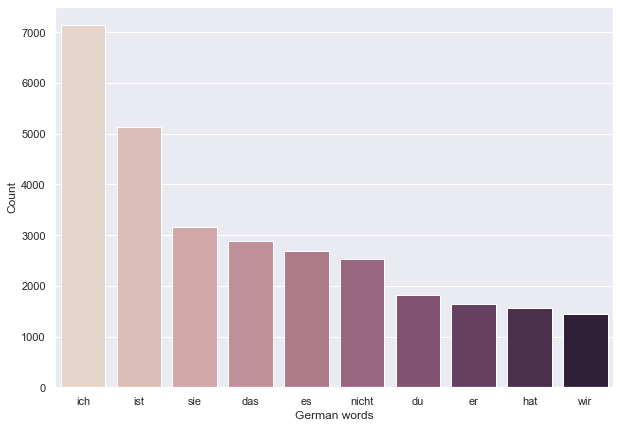

In [ ]:
sns.set(rc={'figure.figsize':(10,7)})
sns.barplot(x="German words", y="Count", data=dfdeuwords, palette = "ch:.11")

Дополним исходный датафрейм столбцами с длиной каждого предложения на обоих языках.

In [ ]:
dfdata['English sentence length'] = englen
dfdata['German sentence length'] = deulen
dfdata

,English sentences,German sentences,English sentence length,German sentence length
0,Hi,Hallo,1,1
1,Hi,Grüß Gott,1,2
2,Run,Lauf,1,1
3,Wow,Potzdonner,1,1
4,Wow,Donnerwetter,1,1
...,...,...,...,...
29995,It snowed all night,Es hat die ganze Nacht geschneit,4,6
29996,It snowed yesterday,Gestern hat es geschneit,3,4
29997,It tastes very good,Es schmeckt sehr gut,4,4
29998,It took all evening,Es dauerte den ganzen Abend,4,5


## Дополнение (Padding)

Необходимый шаг в обработке данных, так как модель рекуррентной сети, которая будет использоваться, требует, чтобы выходные данные были одной длины. Соответственно, необходимо преобразовать все предложения в вектор одной длины - длины самого длинного предложения в датасете. Это делается с помощью pad_sequences из библиотеки Keras. Данная функция заполняет "пустые" слова нулями в векторе.

In [ ]:
encoder_sequences = pad_sequences(engvector, maxlen = maxenglen)
print('Размерность массива английских предложений: ', encoder_sequences.shape)

Размерность массива английских предложений:  (30000, 6)


Выберем вектор из массива и проверим соответствие индексов словам:

In [ ]:
print('Числовая последовательность предложения "Who saw you?" :', encoder_sequences[2717])

print(engindexes['who'])
print(engindexes['saw'])
print(engindexes['you'])

Числовая последовательность предложения "Who saw you?" : [ 0  0  0 60 89  3]
60
89
3


Аналогично для немецких предложений.

In [ ]:
decoder_input_sequences = pad_sequences(deu_startvector, maxlen = maxdeulen, padding='post')
print('Размерность массива немецких предложений input: ', decoder_input_sequences.shape)

Размерность массива немецких предложений:  (30000, 13)


In [ ]:
decoder_output_sequences = pad_sequences(deu_endvector, maxlen = maxdeulen, padding='post')
print('Размерность массива немецких предложений output: ', decoder_output_sequences.shape)

Размерность массива немецких предложений output:  (30000, 13)


In [ ]:
print('Числовая последовательность предложения "Wer sah dich" :' , decoder_input_sequences[2717])

print(deuindexes['<start>'])
print(deuindexes['wer'])
print(deuindexes['sah'])
print(deuindexes['dich'])

Числовая последовательность предложения "Wer sah dich" : [  1  50 131  27   0   0   0   0   0   0   0   0   0]
1
50
131
27


##  Векторное представление слов (Embedding)

Следующий этап это векторное представление слов. В конце этого шага каждое слово должно быть представлено в виде векторов, состоящих из вещественных чисел. 

Для английских предложений в первом случае используем готовую модель GloVe. Данная модель представляет собой алгоритм без учителя для получения векторного представления слова. 

In [ ]:
embeddings_dictionary = dict()

glove_file = open(r'glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

Мы создаем матрицу, где номер строки будет отображать целое значение слова, а столбцы соответствовать размерности слова. Данная матрица будет содержать векторное представление слов для предложений, вводящиеся в кодировщик модели.

In [ ]:
kwords = min(30000, len(engindexes) + 1)
embedding_matrix = np.zeros((kwords, 100))
for word, index in engindexes.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

Проверим векторное представление слова saw и векторное представления слова с индексом 89. Они должны соответствовать.

In [ ]:
print(embeddings_dictionary['saw'])
print(embedding_matrix[89])

[ 0.16038    0.030281  -0.28715   -0.18265   -0.47084   -0.06407
 -0.061913   0.28301    0.15458   -0.41037    0.49095   -0.17235
  0.23249   -0.21068    0.22622   -0.15653   -0.26192    0.046212
 -0.1192     0.18304    0.70213   -0.085788   0.075625  -0.073579
  0.30918   -0.35116   -0.18383   -0.18571    0.36259   -0.42823
 -0.11684    0.36069   -0.057576   0.22383    0.0028594 -0.32032
  0.12244    0.17763    0.10491   -0.069481  -0.66263   -0.36003
  0.37367   -0.1934     0.21858    0.23457    0.44993   -0.1433
  0.2994    -0.96442   -0.14668    0.2475    -0.13986    1.2012
  0.18474   -2.528     -0.55989    0.22973    0.72489    0.64458
 -0.11219    0.8006    -0.47052    0.34465    0.53038   -0.046062
  0.36854    0.16462   -0.09294    0.42797    0.10706    0.14713
 -0.06471   -0.57722   -0.23971    0.34065    0.30964    0.10517
 -0.58066    0.076581   0.5949     0.23875   -0.20855   -0.05278
 -1.1653    -1.1809    -0.3534    -0.62103   -0.38433    0.05255
  0.48298   -0.6071    -

Мы видим, что значения 89-й строки матрицы векторных представлений соответствует векторному представлению слова saw в словаре векторных представлений GloVe.

Чтобы использовать эту матрицу в модели, необходимо создать слой векторных представлений:

In [ ]:
embedding_layer = Embedding(kwords, 100, weights=[embedding_matrix], input_length = maxenglen)

## Создание модели

Прежде чем создавать модель необходимо представить вывод. Как мы посчитали ранее, длина самого длинного немецкого предложения - 13. Значит, пока что пустой массив для вывода будет иметь размерность (количество предложений/записей, длина самого длинного немецкого предложения, количество уникальных слов в выводе).

Для того, чтобы модель делала предсказания, последний слой модели должен быть Dense layer. То есть, чтобы создать верный вывод, следует присвоить 1 к столбцу, номер которого соответствует целому представлению слова.

In [ ]:
decoder_target = np.zeros((len(engsentences), maxdeulen, len(deuindexes)+1),dtype='float32')
print(decoder_target.shape)

for i, d in enumerate(decoder_output_sequences):
    for t, word in enumerate(d):
        decoder_target[i, t, word] = 1
print(decoder_target.shape)

(30000, 13, 7551)
(30000, 13, 7551)


Следующим шагом необходимо создать кодер (encoder) и декодер (decoder). 

Сначала определим кодировщик. Вводом в encoder является предложение на английском, а выводом hidden states и cell state архитектуры LSTM.

In [ ]:
LSTM_NODES = 256

encoder_inputs_placeholder = Input(shape=(maxenglen,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(LSTM_NODES, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

Далее определим decoder. На входе он получает два значения: hidden states и cell state из кодера, а также закодированное предложение на немецком с индикатором $<start>$.

In [ ]:
decoder_inputs_placeholder = Input(shape=(maxdeulen,))

decoder_embedding = Embedding(len(deuindexes)+1, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

Наконец, полученнные из декодиера предложения проходят через dense layer, чтобы предсказать конечный вывод.

In [ ]:
decoder_dense = Dense(len(deuindexes)+1, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

Создание модели:

In [ ]:
model = Model([encoder_inputs_placeholder,decoder_inputs_placeholder], decoder_outputs)
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

Обучение модели. Обучающая и тестовая выборки разделены в соотношении 80 к 20, значит модель обучается на 24000 предложениях и тестируется на оставшихся 6000.

In [ ]:
r = model.fit([encoder_sequences, decoder_input_sequences], decoder_target, batch_size = 128, 
                      epochs = 20,validation_split=0.2,)

Epoch 1/20
188/188 [==============================] - 95s 506ms/step - loss: 1.9967 - accuracy: 0.7214 - val_loss: 1.9592 - val_accuracy: 0.7197
Epoch 2/20
188/188 [==============================] - 144s 766ms/step - loss: 1.4102 - accuracy: 0.7886 - val_loss: 1.7369 - val_accuracy: 0.7463
Epoch 3/20
188/188 [==============================] - 102s 543ms/step - loss: 1.2077 - accuracy: 0.8122 - val_loss: 1.5715 - val_accuracy: 0.7664
Epoch 4/20
188/188 [==============================] - 99s 525ms/step - loss: 1.0707 - accuracy: 0.8278 - val_loss: 1.4700 - val_accuracy: 0.7769
Epoch 5/20
188/188 [==============================] - 97s 517ms/step - loss: 0.9679 - accuracy: 0.8407 - val_loss: 1.3983 - val_accuracy: 0.7875
Epoch 6/20
188/188 [==============================] - 98s 519ms/step - loss: 0.8819 - accuracy: 0.8520 - val_loss: 1.3346 - val_accuracy: 0.7942
Epoch 7/20
188/188 [==============================] - 97s 516ms/step - loss: 0.8089 - accuracy: 0.8619 - val_loss: 1.2917 - val_

Изменение модели под предсказание перевода. Она предсказывает каждое последующее слово, заданное с определенной вероятностью, пока не дойдет до индикатора $<end>$.

In [ ]:
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

Перевод предложений. 

На шаге токенизации слова были индексированы целыми числами. На выходе decoder также выдает целые числа, которые необходимо перевести в последовательность слов на немецком языке. Поэтому мы создаем словари с индексами и соответствующими им словами для входных и выходных данных.

In [ ]:
indexword_input = {v:k for k, v in engindexes.items()}
indexword_target = {v:k for k, v in deuindexes.items()}

Последующий метод будет возвращать предложение на немецком, получив на вход последовательность целых чисел.

In [ ]:
def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = deuindexes['<start>']
    eos = deuindexes['<end>']
    output_sentence = []

    for _ in range(maxdeulen):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = indexword_target[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

## Тестирование модели:

In [ ]:
i = np.random.choice(len(engsentences))
input_seq = encoder_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('Предложение на английском:', engsentences[i])
print('Предсказанный перевод:', translation)
print('Правильный перевод: ', deusentences[i])

Предложение на английском: Perhaps its Tom
Предсказанный перевод: vielleicht ist es tom
Правильный перевод:  Vielleicht ist es Tom


Для оценки модели используется оценка BLEU Score:

In [ ]:
lower = deusentences[i].lower()
reference_translation = [lower.split()]
candidate_translation = translation.split()
                         
print("BLEU Score: ",bleu.sentence_bleu(reference_translation, candidate_translation, weights = (0.5, 0.5)))

BLEU Score:  1.0


In [ ]:
i = np.random.choice(len(engsentences))
input_seq = encoder_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('Предложение на английском:', engsentences[i])
print('Предсказанный перевод:', translation)
print('Правильный перевод: ', deusentences[i])

Предложение на английском: Are you going too
Предсказанный перевод: gehst du auch
Правильный перевод:  Gehst du auch dorthin


In [ ]:
lower = deusentences[i].lower()
reference_translation = [lower.split()]
candidate_translation = translation.split()
                         
print("BLEU Score: ",bleu.sentence_bleu(reference_translation, candidate_translation, weights = (0.5, 0.5)))

BLEU Score:  0.7165313105737893


In [ ]:
i = np.random.choice(len(engsentences))
input_seq = encoder_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('Предложение на английском:', engsentences[i])
print('Предсказанный перевод:', translation)
print('Правильный перевод: ', deusentences[i])

Предложение на английском: Im really sorry
Предсказанный перевод: es tut mir wirklich leid
Правильный перевод:  Es tut mir wirklich leid


In [ ]:
lower = deusentences[i].lower()
reference_translation = [lower.split()]
candidate_translation = translation.split()
                         
print("BLEU Score: ",bleu.sentence_bleu(reference_translation, candidate_translation, weights = (0.5, 0.5)))

BLEU Score:  1.0


# Вариант #2

Рассмотрим немного другой алгоритм обработки исходных данных для модели нейронного машинного обучения, которая также основывается на принципе Encoder-Decoder. На тех же данных проведем токенизацию данных вручную, а не с помощью библиотеки Keras, так же как и этап padding. Для векторного представления английских слов не используется готова модель GloVe.

Скопируем исходный датасет с уже очищенными данными:

In [ ]:
dfencdec = dfdata.copy(deep=True)
dfencdec

,English sentences,German sentences,English sentence length,German sentence length
0,Hi,Hallo,1,1
1,Hi,Grüß Gott,1,2
2,Run,Lauf,1,1
3,Wow,Potzdonner,1,1
4,Wow,Donnerwetter,1,1
...,...,...,...,...
29995,It snowed all night,Es hat die ganze Nacht geschneit,4,6
29996,It snowed yesterday,Gestern hat es geschneit,3,4
29997,It tastes very good,Es schmeckt sehr gut,4,4
29998,It took all evening,Es dauerte den ganzen Abend,4,5


## Индикаторы начала и конца предложения

Как и ранее, отметим начало и конец немецких предложений, но не будем разбивать их на два разных массива.

In [ ]:
dfencdec['German sentences'] = dfencdec['German sentences'].apply(lambda x : 'START_ '+ x + ' _END')
dfencdec

,English sentences,German sentences,English sentence length,German sentence length
0,Hi,START_ Hallo _END,1,1
1,Hi,START_ Grüß Gott _END,1,2
2,Run,START_ Lauf _END,1,1
3,Wow,START_ Potzdonner _END,1,1
4,Wow,START_ Donnerwetter _END,1,1
...,...,...,...,...
29995,It snowed all night,START_ Es hat die ganze Nacht geschneit _END,4,6
29996,It snowed yesterday,START_ Gestern hat es geschneit _END,3,4
29997,It tastes very good,START_ Es schmeckt sehr gut _END,4,4
29998,It took all evening,START_ Es dauerte den ganzen Abend _END,4,5


Определим "словарный запас" каждого языка в наших данных, создав множество из уникальных слов английского и немецкого языков.

In [ ]:
eng_vocab = set()
for eng in dfencdec['English sentences']:
    for word in eng.split():
        if word not in eng_vocab:
            eng_vocab.add(word)

print ('Количество уникальных слов в английском языке:', len(eng_vocab))

Количество уникальных слов в английском языке: 5140


Заметим, что в первом случае при токенизации с помощью библиотеки Keras, обнаружилось ~4700 уникальных слов, по сравнению с обнаружением их с помощью циклов.

In [ ]:
deu_vocab=set()
for deu in dfencdec['German sentences']:
    for word in deu.split():
        if word not in deu_vocab:
            deu_vocab.add(word)
            
print ('Количество уникальных слов в немецком языке:', len(deu_vocab))

Количество уникальных слов в немецком языке: 8454


В случае немецкого языка уникальных слов также оказалось больше, чем при использовании библиотеки.

Длина самых длинных предложений в обоих языках:

In [ ]:
maxlen_input = max(dfencdec['English sentence length'])
maxlen_target = max(dfencdec['German sentence length'])
print ('Длина самого длинного английского предложения', maxlen_input)
print('Длина самого длинного немецкого предложения', maxlen_target)

Длина самого длинного английского предложения 6
Длина самого длинного немецкого предложения 12


In [ ]:
maxlen_target += 1

## Токенизация (tokenization)

Сортировка массивов со словами по алфавиту и создание переменных со значением количества уникальных слов для модели.

In [ ]:
input_words = sorted(list(eng_vocab))
target_words = sorted(list(deu_vocab))
kencoder_tokens = len(eng_vocab) + 1
kdecoder_tokens = len(deu_vocab) + 1

Присвоим каждому слову собственный индекс (токенизируем):

In [ ]:
input_tokenindex = dict([(word, i+1) for i, word in enumerate(input_words)])
target_tokenindex = dict([(word, i+1) for i, word in enumerate(target_words)])

Для алгоритма декодировки создадим "обратный" словарь, где ключами будут индексы, а не слова. 

In [ ]:
reverse_input_charindex = dict((i, word) for word, i in input_tokenindex.items())
reverse_target_charindex = dict((i, word) for word, i in target_tokenindex.items())

Перед разделением данных на обучающую и тестовую выборки перемешаем предложения в датасете.

In [ ]:
dfencdec = shuffle(dfencdec)
dfencdec

,English sentences,German sentences,English sentence length,German sentence length
16384,Tom was bluffing,START_ Tom bluffte _END,3,2
19255,It was pure chaos,START_ Es war das reinste Chaos _END,4,5
26125,Tom is still alive,START_ Tom ist noch am Leben _END,4,5
4265,Are you a fan,START_ Bist du ein Fan _END,4,4
25410,The floor is dirty,START_ Der Fußboden ist schmutzig _END,4,4
...,...,...,...,...
28970,I have no allergies,START_ Ich habe keine Allergien _END,4,4
10807,Lets get a cab,START_ Lassen Sie uns ein Taxi nehmen _END,4,6
13076,Did you enjoy it,START_ Hat es dir Freude gemacht _END,4,5
15969,Tom is so stupid,START_ Tom ist so dumm _END,4,4


### Разделим данные на обучающую и тестовую выборки

Снова разделяем данные на обучающую и тестовую выборки в отношении 80 к 20:

In [ ]:
X = dfencdec['English sentences']
y = dfencdec['German sentences']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state = 11)
X_train.shape, X_test.shape

((24000,), (6000,))

### Создание модели

Сохраним полученные обучающие и тестовые данные:

In [ ]:
X_train.to_pickle('X_train.pkl')
X_test.to_pickle('X_test.pkl')

Создадим генератор batches, т.е. генератор определенного количества примеров для одной итерации. Внутри этого генератора также происходит padding, который в варианте 1 был осуществлен отдельно. Количество примеров возьмем 128.  

In [ ]:
def batch_generator(X = X_train, y = y_train, batch_size = 128):
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, maxlen_input),dtype = 'float32')
            decoder_input_data = np.zeros((batch_size, maxlen_target),dtype = 'float32')
            decoder_target_data = np.zeros((batch_size, maxlen_target, kdecoder_tokens),dtype = 'float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j + batch_size], y[j:j + batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_tokenindex[word] 
                for t, word in enumerate(target_text.split()):
                    if t < len(target_text.split())-1:
                        decoder_input_data[i, t] = target_tokenindex[word] 
                    if t > 0:
                        decoder_target_data[i, t - 1, target_tokenindex[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

Векторное представление слов во втором случае произведем без использования готовой модели GloVe.

Encoder и decoder создаются так же, как и в первом варианте.

In [ ]:
latent_dim = 300

In [ ]:
encoder_inputs = Input(shape = (None,))
enc_emb =  Embedding(kencoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state = True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

encoder_states = [state_h, state_c]

In [ ]:
decoder_inputs = Input(shape = (None,))
dec_emb_layer = Embedding(kdecoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(kdecoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

Создание модели:

In [ ]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [ ]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 20

Обучение модели:

In [ ]:
model.fit_generator(generator = batch_generator(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs = epochs,
                    validation_data = batch_generator(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

Epoch 1/20
187/187 [==============================] - 112s 598ms/step - loss: 1.8430 - val_loss: 1.5821
Epoch 2/20
187/187 [==============================] - 108s 578ms/step - loss: 1.4795 - val_loss: 1.4264
Epoch 3/20
187/187 [==============================] - 107s 574ms/step - loss: 1.3259 - val_loss: 1.3114
Epoch 4/20
187/187 [==============================] - 111s 594ms/step - loss: 1.2046 - val_loss: 1.2273
Epoch 5/20
187/187 [==============================] - 102s 544ms/step - loss: 1.1020 - val_loss: 1.1559
Epoch 6/20
187/187 [==============================] - 103s 552ms/step - loss: 1.0126 - val_loss: 1.1015
Epoch 7/20
187/187 [==============================] - 119s 635ms/step - loss: 0.9362 - val_loss: 1.0573
Epoch 8/20
187/187 [==============================] - 113s 603ms/step - loss: 0.8678 - val_loss: 1.0266
Epoch 9/20
187/187 [==============================] - 113s 602ms/step - loss: 0.8052 - val_loss: 0.9877
Epoch 10/20
187/187 [==============================] - 108s 577m

In [ ]:
model.save_weights('nmt_weights.h5')

Изменение модели под предсказание перевода. Она предсказывает каждое последующее слово, пока не дойдет до индикатора конца предложения.

In [ ]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) 

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) 

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

Зададим функцию, возвращающую расшифрованное переведенное предложение: 

In [ ]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_tokenindex['START_']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_tokenindex = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_charindex[sampled_tokenindex]
        decoded_sentence += ' '+sampled_char

        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_tokenindex

        states_value = [h, c]

    return decoded_sentence

## Тестирование модели

In [ ]:
train_gen = batch_generator(X_train, y_train, batch_size = 1)
k=-1

In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Предложение на английском:', X_train[k:k+1].values[0])
print('Предсказанный перевод:', decoded_sentence[:-4])
print('Правильный перевод:', y_train[k:k+1].values[0][6:-4])

Предложение на английском: Is your mom here
Предсказанный перевод:  Ist deine Mutter hier 
Правильный перевод:  Ist deine Mutter hier 


In [ ]:
reference_translation = [y_train[k:k+1].values[0][6:-4].split()]
candidate_translation = decoded_sentence[:-4].split()
                         
print("BLEU Score: ",bleu.sentence_bleu(reference_translation, candidate_translation, weights = (0.5, 0.5)))

BLEU Score:  1.0


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Предложение на английском:', X_train[k:k+1].values[0])
print('Предсказанный перевод:', decoded_sentence[:-4])
print('Правильный перевод:', y_train[k:k+1].values[0][6:-4])

Предложение на английском: Is it near here
Предсказанный перевод:  Ist es in der Nähe 
Правильный перевод:  Ist es hier in der Nähe 


In [ ]:
reference_translation = [y_train[k:k+1].values[0][6:-4].split()]
candidate_translation = decoded_sentence[:-4].split()
                         
print("BLEU Score: ",bleu.sentence_bleu(reference_translation, candidate_translation, weights = (0.5, 0.5)))

BLEU Score:  0.7090416310250969


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Предложение на английском:', X_train[k:k+1].values[0])
print('Предсказанный перевод:', decoded_sentence[:-4])
print('Правильный перевод:', y_train[k:k+1].values[0][6:-4])

Предложение на английском: I ran to my mother
Предсказанный перевод:  Ich rannte um dem Haus 
Правильный перевод:  Ich rannte zu meiner Mutter 


In [ ]:
reference_translation = [y_train[k:k+1].values[0][6:-4].split()]
candidate_translation = decoded_sentence[:-4].split()
                         
print("BLEU Score: ",bleu.sentence_bleu(reference_translation, candidate_translation, weights = (0.5, 0.5)))

BLEU Score:  0.316227766016838


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Предложение на английском:', X_train[k:k+1].values[0])
print('Предсказанный перевод:', decoded_sentence[:-4])
print('Правильный перевод:', y_train[k:k+1].values[0][6:-4])

Предложение на английском: Tom is persuasive
Предсказанный перевод:  Tom ist eingeschritten 
Правильный перевод:  Tom ist überzeugend 


In [ ]:
reference_translation = [y_train[k:k+1].values[0][6:-4].split()]
candidate_translation = decoded_sentence[:-4].split()
                         
print("BLEU Score: ",bleu.sentence_bleu(reference_translation, candidate_translation, weights = (0.5, 0.5)))

BLEU Score:  0.5773502691896257


В обоих случаях модель успешно переводит предложения, однако по оценкам BLEU в первом случае модель лучше предсказывает перевод предложений с английского на немецкий. Можно сделать вывод, что преобразование данных эффективнее по качеству и времени проводить с помощью готовых атрибутов библиотек, а также моделей, находящихся в общем доступе.